In [10]:
import os
import time
import joblib
import warnings
import numpy as np
import pandas as pd
from tqdm import trange
import matplotlib.pyplot as plt
import seaborn as sns

import pennylane as qml
from pennylane import numpy as pnp
from pennylane import math

from sklearn.utils import resample
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

warnings.filterwarnings("ignore")

In [ ]:
start_time = time.time()

# Load and preprocess data
df = pd.read_csv('mergedTop20.csv')

features = ["Bwd Packet Length Std", "Flow Bytes/s", "Total Length of Fwd Packets", "Fwd Packet Length Std",
            "Flow IAT Std", "Flow IAT Min", "Fwd IAT Total", "Flow Duration", "Bwd Packet Length Max",
            "Flow IAT Max", "Flow IAT Mean", "Total Length of Bwd Packets", "Fwd Packet Length Min",
            "Bwd Packet Length Mean", "Flow Packets/s", "Fwd Packet Length Mean", "Total Backward Packets",
            "Fwd Packet Length Max", "Total Fwd Packets", "Bwd Packet Length Min", "Label"]

df = df[features].fillna(0)
df['Label'] = df['Label'].apply(lambda x: 1 if x == "BENIGN" else -1)
df_minority = df[df['Label'] == -1]
df_majority = df[df['Label'] == 1]

df_minority_upsampled = resample(df_minority, 
                                 replace=True,
                                 n_samples=len(df_majority),
                                 random_state=42)

df_balanced = pd.concat([df_majority, df_minority_upsampled])

X = df_balanced.drop("Label", axis=1)
y = df_balanced["Label"]

# Scale and reduce features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA(n_components=4)
X_pca = pca.fit_transform(X_scaled)

# Normalize to [0, 2π] for angle encoding
X_encoded = (X_pca - X_pca.min()) / (X_pca.max() - X_pca.min()) * 2 * np.pi

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, train_size=2000, test_size=400, stratify=y, random_state=42
)

y_train = y_train.to_numpy()
y_test = y_test.to_numpy()

# Quantum circuit
n_qubits = X_train.shape[1]
dev = qml.device("default.qubit", wires=n_qubits)

@qml.qnode(dev, interface="autograd")
def circuit(x, weights):
    # Feature encoding
    for i in range(n_qubits):
        qml.RY(x[i], wires=i)
    # Ansatz
    qml.templates.StronglyEntanglingLayers(weights, wires=range(n_qubits))
    return qml.expval(qml.PauliZ(0))

# Classifier output
def variational_classifier(weights, x):
    return math.tanh(circuit(x, weights))

# Loss and accuracy
def square_loss(y_true, y_pred):
    return pnp.mean((y_true - y_pred) ** 2)

def accuracy(y_true, y_pred):
    return pnp.mean(math.sign(y_pred) == y_true)

# Training parameters
np.random.seed(42)
weights = pnp.array(0.01 * np.random.randn(3, n_qubits, 3), requires_grad=True)
opt = qml.GradientDescentOptimizer(stepsize=0.1)
epochs = 100
batch_size = 50
steps_per_epoch = len(X_train) // batch_size

losses = []

# Training loop with tqdm
print("Training VQC...")
for epoch in trange(epochs, desc="Training Epochs"):
    for _ in range(steps_per_epoch):
        batch_indices = np.random.randint(0, len(X_train), batch_size)
        x_batch = X_train[batch_indices]
        y_batch = y_train[batch_indices]

        def cost(weights):
            y_preds = math.stack([variational_classifier(weights, x) for x in x_batch])
            return square_loss(y_batch, y_preds)

        weights = opt.step(cost, weights)

    # Track loss per epoch
    y_train_preds = pnp.array([variational_classifier(weights, x) for x in X_train])
    loss = square_loss(y_train, y_train_preds)
    losses.append(loss)


Training VQC...


Training Epochs: 100%|██████████| 100/100 [3:36:32<00:00, 129.92s/it] 



Classification Report:
              precision    recall  f1-score   support

          -1       0.86      0.42      0.57       200
           1       0.62      0.93      0.74       200

    accuracy                           0.68       400
   macro avg       0.74      0.68      0.66       400
weighted avg       0.74      0.68      0.66       400



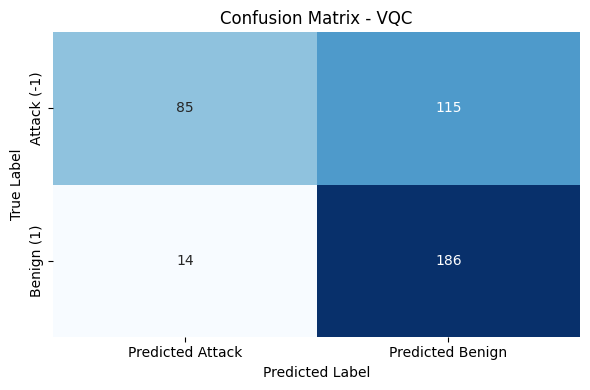

In [ ]:
#Prediction on test data
y_test_preds = pnp.array([variational_classifier(weights, x) for x in X_test])
y_pred_labels = math.sign(y_test_preds)
y_pred_labels = y_pred_labels.numpy()

# Evaluation
print("\nClassification Report:")
print(classification_report(y_test, y_pred_labels))

# Saving
os.makedirs("Result", exist_ok=True)
np.save("Result/pennylane_weights.npy", weights)
joblib.dump(scaler, "Result/pennylane_scaler.pkl")
joblib.dump(pca, "Result/pennylane_pca_transform.pkl")
joblib.dump(X.columns.tolist(), "Result/pennylane_features_used.pkl")

# Confusion matrix
cm = confusion_matrix(y_test, y_pred_labels, labels=[-1, 1])
cm_df = pd.DataFrame(cm, index=["Attack (-1)", "Benign (1)"], columns=["Predicted Attack", "Predicted Benign"])

# Plot heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(cm_df, annot=True, fmt='d', cmap="Blues", cbar=False)
plt.title("Confusion Matrix - VQC")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.savefig("Result/confusion_matrix_vqc.png")
plt.show()